In [1]:
import numpy as np
import torch as pt
import torchvision
from torch.nn import functional as F
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.preprocessing import LabelBinarizer

In [2]:
train_set = torchvision.datasets.MNIST("./data", train=True, transform=torchvision.transforms.ToTensor(), download=True)
test_set = torchvision.datasets.MNIST("./data", train=False, transform=torchvision.transforms.ToTensor(), download=True)

#### Train dataset -  50 samples from each cass in trainset

In [3]:
train_classes = [label for _, label in train_set]
Counter(train_classes)

Counter({5: 5421,
         0: 5923,
         4: 5842,
         1: 6742,
         9: 5949,
         2: 5958,
         3: 6131,
         6: 5918,
         7: 6265,
         8: 5851})

In [4]:
#number of samples from each classs
n_examples = 50
examples = {i: [] for i in range(10)}
for x, i in train_set:
    if all([len(ex) == n_examples for ex in examples.values()]):
        break
    
    if len(examples[i]) < n_examples:
        examples[i].append(x)

x_train=[]
y_train = []
for i in range(10):
    for j in range(n_examples):
        x=examples[i][j].numpy()
        x_train.append(x)
        y_train.append(i)
y_train = LabelBinarizer().fit_transform(y_train)

#### Test Dataset - 10 samples from each class in testset

In [5]:
test_classes = [label for _, label in test_set]
Counter(test_classes)

Counter({7: 1028,
         2: 1032,
         1: 1135,
         0: 980,
         4: 982,
         9: 1009,
         5: 892,
         6: 958,
         3: 1010,
         8: 974})

In [6]:
n_examples = 10
examples = {i: [] for i in range(10)}
for x, i in test_set:
    if all([len(ex) == n_examples for ex in examples.values()]):
        break
    
    if len(examples[i]) < n_examples:
        examples[i].append(x)

x_test=[]
y_test = []
for i in range(10):
    for j in range(n_examples):
        x=examples[i][j].numpy()
        x_test.append(x)
        y_test.append(i)
y_test = LabelBinarizer().fit_transform(y_test)

## Question1

In [7]:
#function to generate kernels of given size and count
def generateKernel(no_kernels, c2=0):
    if(c2==0):
        kernel = np.empty([no_kernels,5,5])
        for i in range (0,np.shape(kernel)[0]):
            kernel[i] = np.random.rand(np.shape(kernel)[1],np.shape(kernel)[2])
    else:    
        kernel = np.empty([no_kernels,5,5,c2])
        for i in range (0,np.shape(kernel)[0]):
            kernel[i] = np.random.rand(np.shape(kernel)[1],np.shape(kernel)[2],c2)
    return kernel

In [8]:
#function that takes care of relection padding of the give image on all the edges
def padding(kernel_size,image):
    W,H=image.shape
    pad_size=kernel_size-1   #number of layers of pad
    padded_image=[[0]*(W+2*(kernel_size-1))]*(H+2*(kernel_size-1))
    padded_image=np.asarray(padded_image)
    padded_image[pad_size:pad_size+W, pad_size:pad_size+H] = image

    #row padding
    for i in range(pad_size):
        padded_image[i,pad_size:pad_size+H]=image[pad_size-1-i]  
        padded_image[W+2*kernel_size-2-(i+1),pad_size:pad_size+H] = image[W-(pad_size-i)]
    #column padding
    for j in range(pad_size):
        padded_image[:,j]=padded_image[:,2*pad_size-(j+1)]
        padded_image[:,(H+2*kernel_size-2)-(j+1)]=padded_image[:,(H+2*kernel_size-2)-(2*pad_size-j)]
        
    return padded_image

In [9]:
#non linear functions
def sigmoid(x):
    return 1/(1+np.exp(-x))

def relu(x):
    return np.maximum(x,0)

def softmax(x):
    y = np.empty(x.shape)
    for i in range(0,np.shape(x)[0]):
        y[i] = (np.exp(x[i])/np.sum(np.exp(x)))
    return y
    
def softmaxprime(softmax):
    s = softmax.reshape(-1,1)
    return np.diagflat(s) - np.dot(s, s.T)

def reluprime(x):
    return 1*(x>0)

In [10]:
#max pool the convolved image
def max_pool(conv_image,stride):
    W,H=conv_image.shape
    mp_R =int((W-2)/stride+1)
    mp_C= int((H-2)/stride+1)
    mp_output = np.empty([mp_R,mp_C])
    x=0
    y=0
    for i in range(0,mp_R):
        for j in range(0,mp_C):
            temp = np.array([[conv_image[i][j],conv_image[i][j+1]],[conv_image[i+1][j],conv_image[i+1][j+1]]])
            mp_output[x][y] = np.amax(temp)
            y=y+1
            j = j + stride - 1
        y = 0
        x+=1
        i = i + stride - 1
    return mp_output

#avg pool the convolved image
def avg_pool(conv_image,stride):
    W,H=conv_image.shape
    avg_R=W-(2-1)*stride
    avg_C=H-(2-1)*stride
    avg = np.empty([avg_R,avg_C])
    x=0
    y=0
    for i in range(avg_R):
        for j in range(avg_C):
            temp = np.array([[conv_image[i][j],conv_image[i][j+1]],[conv_image[i+1][j],conv_image[i+1][j+1]]])
            avg[x][y] = np.sum(temp)/4
            y=y+1
            j = j + stride - 1
        y = 0
        x+=1
        i = i + stride - 1
    return avg


In [11]:
#Convolution function that convolves image with kernel
def convolution(image,kernel,stride,pad, non_linear_func):
    if(pad == 1 ):
        J=padding(kernel.shape[0],image)
    else:
        J=image
    kernel = np.flipud(np.fliplr(kernel))                        #flipping the kernel
    padded_r,padded_c = J.shape
    kernel_r,kernel_c = kernel.shape
    conv_r,conv_c = padded_r-kernel_r+1,padded_c-kernel_c+1
    conv_img=np.zeros([conv_r,conv_c])
    
    for i in range(conv_r):
        for j in range(conv_c):
            s = 0
            for p in range(kernel_r):
                for q in range(kernel_c):
                    s += J[i+p][j+q] * kernel[p][q]               ####convolution formula
            conv_img[i][j] = s
            j = j+stride-1
        i = i+stride-1

    conv_img = relu(conv_img)

    return conv_img

In [12]:
def pooling(conv_output,pool_func,stride): #pooling from 2x2 matrices
    if pool_func == "max":
        result=max_pool(conv_output,stride)
    if pool_func == "avg":
        result = avg_pool(conv_output,stride)
    return result

In [13]:
def pool_layer(image,pool_func,stride):
    c,W,H=image.shape
    mp_R =int((W-2)/stride+1)
    mp_C= int((H-2)/stride+1)
    result = np.empty([c,mp_R,mp_C])
    for i in range(0,np.shape(image)[0]):
        result[i] = pooling(image[i],pool_func,stride)
    return result


In [14]:
#Convolve 2d image
def convlayer_pre(image, kernel, stride, padding, non_linear_func):
    if(padding==1):
        pad=kernel.shape[0]-1
    else :
        pad=0
        
    c,W,H=image.shape
    m=W+2*(pad)
    n=H+2*(pad)
    rows = m-(kernel[0].shape[0]-1)
    cols= n-(kernel[0].shape[1]-1)
    result = np.zeros([np.shape(kernel)[0],rows,cols])
    for i in range (0,np.shape(kernel)[0]):
        kernel_temp=kernel[i]
        result[i]=convolution(image[0],kernel_temp,stride, padding,non_linear_func)
    return result

In [15]:
#Convolve 3d image
def convlayer(image, kernel, stride, padding, non_linear_func):
    if(padding==1):
        pad=kernel[0].shape[0]-1
    else :
        pad=0
    image=image.transpose(2,0,1)
    c,W,H=image.shape
    m=W+2*(pad)
    n=H+2*(pad)
    rows = m-(kernel[0].shape[0]-1)
    cols= n-(kernel[0].shape[1]-1)
    result = np.zeros([np.shape(kernel)[0],rows,cols])
    for i in range (0,np.shape(kernel)[0]):
        kernel_temp=kernel[i]
        kernel_temp=kernel_temp.transpose(2,0,1)
        for j in range(kernel_temp.shape[0]):
            result[i]+=convolution(image[0],kernel_temp[j],stride, padding,non_linear_func)
    return result

In [16]:
def mlp_func(vec,hiddden_layers,each_hl_size,non_linear_func,size_output,Weight):
    for i in range(0,1):
        vec = relu(vec)
    mlp_out = np.matmul(vec.T,Weight)
    return mlp_out 

In [17]:
def flatten(pool_out,Weight):
    W,C,H = pool_out.shape
    pool_out= pool_out.reshape(W*H*C,1)
    result = np.matmul(Weight,pool_out)
    return result

## Question2

### Function to compute cross entropy loss

In [18]:
#function to fins cross entropy loss
def cross_entropy_loss(y_true,y_pred):
    err=0
    y_pred = y_pred.flatten()
    y_true = y_true.reshape(10)
    y_pred = y_pred.reshape(10)
    for i in range(0,10):
        err = err + y_true[i]*np.log(1/y_pred[i])
    return err

### Function to compute accuracy percentage

In [19]:
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

## Question3

### Backpropogation functions

#### Vanilla SGD

In [20]:
def Vanilla_SGD(y_pred,y,flatten_output,Conv2_out,W1,W2):
    Gamma = 0.001
    Conv2_out_modified = Conv2_out.reshape(Conv2_out.shape[0]*Conv2_out.shape[1]*Conv2_out.shape[2],1)
    
    size1=W2.shape[0]
    size2=W2.shape[1]
    size3=W1.shape[0]
    size4=W1.shape[1]
    
    for i in range(size1):
        for j in range(size2):
            loss = -(y[j]/y_pred[0][j])*softmaxprime(y_pred)[0][j]
            W2_dash = loss*flatten_output[i][0]
            W2[i][j] = W2[i][j] - Gamma*W2_dash

   
    for i in range(size4):
        for j in range(size3):
            loss = np.sum(-(y/y_pred[0])*softmaxprime(y_pred)*W1[j][i])*reluprime(flatten_output[j][0])
            W1_dash = loss*Conv2_out_modified[i][0]
            W1[j][i] = W1[j][i] - Gamma*W1_dash
            
    return W1,W2

#### Momentum SGD

In [21]:
def Momentum_SGD(y_pred,y_true,flatten_output,Conv2_out,W1,W2,dvW1,dvW2):
    Gamma = 0.001
    alpha = 0.9 
    
    Conv2_out_modi = Conv2_out.reshape(Conv2_out.shape[0]*Conv2_out.shape[1]*Conv2_out.shape[2],1)
    
    size1=W2.shape[0]
    size2=W2.shape[1]
    size3=W1.shape[0]
    size4=W1.shape[1]
    
    for i in range(size1):
        for j in range(0,size2):
            loss = -(y_true[j]/y_pred[0][j])*softmaxprime(y_pred)[0][j]
            W2_dash = loss*flatten_output[i][0]
            dvW2[i][j] = alpha*dvW2[i][j] + 0.1*W2_dash
            W2[i][j] = W2[i][j] - Gamma*dvW2[i][j]

    for i in range(size4):
        for j in range(0,size3):
            loss = np.sum(-(y_true/y_pred[0])*softmaxprime(y_pred)*W1[j][i])*reluprime(flatten_output[j][0])
            W1_dash = loss*Conv2_out_modi[i][0]
            dvW1[j][i] = alpha*dvW1[j][i] + 0.1*W1_dash
            W1[j][i] = W1[j][i] - Gamma*dvW1[j][i]
            
    return W1,W2,dvW1,dvW2

#### RMSProp SGD

In [22]:
def RMS_prop_SGD(y_pred,y_true,flatten_output,Conv2_out,W1,W2,r1,r2):
    ep = 1e-7
    Gamma = 0.001
    rho = 0.9

    Conv2_out_modi = Conv2_out.reshape(Conv2_out.shape[0]*Conv2_out.shape[1]*Conv2_out.shape[2],1)

    size1=W2.shape[0]
    size2=W2.shape[1]
    size3=W1.shape[0]
    size4=W1.shape[1]    
    
    for i in range(size1):
        for j in range(size2):
            loss = -(y_true[j]/y_pred[0][j])*softmaxprime(y_pred)[0][j]
            W2_dash = loss*flatten_output[i][0]
            W2[i][j] = W2[i][j] - ep/(np.sqrt(Gamma+r2))*W2_dash
            r2 = (1-rho)*r2 + rho*loss**2
    

    for i in range(size4):        
        for j in range(size3):            
            loss = np.sum(-(y_true/y_pred[0])*softmaxprime(y_pred)*W1[j][i])*reluprime(flatten_output[j][0])
            W1_dash = loss*Conv2_out_modi[i][0]           
            W1[j][i] = W1[j][i] - ep/(np.sqrt(Gamma+r1))*W1_dash           
            r1 = (1-p)*r1 + p*loss**2
    
    
    return W1,W2,r1,r2

## Question1 feed forward continued

### Train function

In [23]:
batch_size=1

def train(X_train,y_train,epoch_no,W1,W2,r1,r2,dvW1,dvW2,sgd_variant):
    error=0
    actual=[]
    predicted=[]
    
    kernel1 = generateKernel(4)                   #4 kernels of size 5X5
    kernel2 = generateKernel(4,4)                 #4 kernels of size 5X5X4
    
   
    train_samples=np.shape(X_train)[0]
    y_pred = np.empty([train_samples,1,10])        #array to store the final preditions after the MLP
    
       
    for i in range(train_samples):
        if i<3:
            #plotting the first three samples' original image
            plt_image=X_train[i].transpose(1,2,0)
            plt.imshow(plt_image)
            plt.show()
            
        Conv_out1 = convlayer_pre(X_train[i],kernel1, 1, 0, "relu")
        acti_map1 = pool_layer(Conv_out1,"max",2)

        
        if i<3:
            #plotting the first three samples' activation maps after the first convolution 
            plt_image=acti_map1.transpose(1,2,0)
            plt.imshow(plt_image[0])
            plt.show()

        acti_map1 = np.swapaxes(acti_map1,0,2)
        acti_map1 = np.swapaxes(acti_map1,0,1)
        
        Conv_out2 = convlayer(acti_map1, kernel2, 1, 0, "relu")
        acti_map2 = pool_layer(Conv_out2,"max",2)
        
        if i<3:
            #plotting the first three samples' activation maps after the final convolution 
            plt_image=acti_map2.transpose(1,2,0)
            plt.imshow(plt_image[0])
            plt.show()
            
        acti_map2 = np.swapaxes(acti_map2,0,2)
        acti_map2 = np.swapaxes(acti_map2,0,1)
        
        if epoch_no ==0:
            W1 = np.random.rand(49,np.shape(acti_map2)[0]*np.shape(acti_map2)[1]*np.shape(acti_map2)[2])
            dvW1 = np.zeros([W1.shape[0],W1.shape[1]])
            r1 = 0.01
            r2 = 0.01
                                                      
        flatten_out = flatten(acti_map2,W1)
        flatten_out = (flatten_out - np.min(flatten_out)) / (np.max(flatten_out) - np.min(flatten_out))
        
        ft_out_size=np.shape(flatten_out)[0]
        
        if epoch_no ==0:
            W2 = np.random.rand(ft_out_size,10)
            dvW2 = np.zeros([W2.shape[0],W2.shape[1]])
    
    
        temp=mlp_func(flatten_out,1,ft_out_size,"relu",10,W2)        
        y_pred[i] = temp
        y_pred[i] = y_pred[i].reshape(10)
        
        y_pred[i]=softmax(y_pred[i])
        
        error += cross_entropy_loss(y_train[i],y_pred[i])
        actual.append(np.argmax(y_train[i]))
        predicted.append(np.argmax(y_pred[i]))
        
        #can experiment with different batch sizes and different variants of SGD
        if i%batch_size == 0:
            if sgd_variant == "vanilla":
                W1,W2= Vanilla_SGD(y_pred[i],y_train[i],flatten_out,acti_map2,W1,W2)
            if sgd_variant == "momentum":
                W1,W2,dvW1,dvW2  = Momentum_SGD(y_pred[i],y_train[i],flatten_out,acti_map2,W1,W2,dvW1,dvW2)
            if sgd_variant == "rmsprop":
                W1,W2,r1,r2 = RMS_prop_SGD(y_pred[i],y_train[i],flatten_out,acti_map2,W1,W2,r1, r2)
                
    return error,W1,W2,r1, r2,dvW1,dvW2,actual,predicted

### Test function

In [24]:
def test(X_test,y_test,W1,W2
        ):
    error=0
    actual=[]
    predicted=[]
    
    X=[]
    kernel1 = generateKernel(4)                   #4 kernels of size 5X5
    kernel2 = generateKernel(4,4)                 #4 kernels of size 5X5X4
 
  
    test_samples=np.shape(X_test)[0]
    y_pred = np.empty([test_samples,1,10])        #array to store the final preditions after the MLP
    
    for i in range(test_samples):        
        Conv_out1 = convlayer_pre(X_test[i],kernel1, 1, 0, "relu")   #first convolution layer
        acti_map1 = pool_layer(Conv_out1,"max",2)
        
        acti_map1 = np.swapaxes(acti_map1,0,2)
        acti_map1 = np.swapaxes(acti_map1,0,1)
        
        Conv_out2 = convlayer(acti_map1, kernel2, 1, 0, "relu")     #second convolution layer
        acti_map2 = pool_layer(Conv_out2,"max",2)
        
        acti_map2 = np.swapaxes(acti_map2,0,2)
        acti_map2 = np.swapaxes(acti_map2,0,1)
        
        flatten_out = flatten(acti_map2,W1)                        #flattening layer 
        flatten_out = (flatten_out - np.min(flatten_out)) / (np.max(flatten_out) - np.min(flatten_out))
        
            
        ft_out_size= np.shape(flatten_out)[0]
        temp=mlp_func(flatten_out,1,ft_out_size,"relu",10,W2)   #MLP layer       

        y_pred[i] = temp
        y_pred[i] = y_pred[i].reshape(10)
        y_pred[i]=softmax(y_pred[i])                         #final predictions after softmax is applied
        
        X.append(y_pred[i].flatten().tolist())
        error += cross_entropy_loss(y_test[i],y_pred[i])     #cross entropy loss is calculated  
        actual.append(np.argmax(y_test[i]))
        predicted.append(np.argmax(y_pred[i]))
        
    return error,actual,predicted,X

## Questions 4+5

Function to shuffle the data (x_train, y_train)

In [25]:
import random
def shuffle(x_train,y_train):
    y_train=y_train.tolist()
    temp = list(zip(x_train, y_train))
    random.shuffle(temp)
    res1, res2 = zip(*temp)
    res1, res2 = list(res1), np.array(list(res2))
    return res1, res2
    

#### Train - Test

 training epoch 0


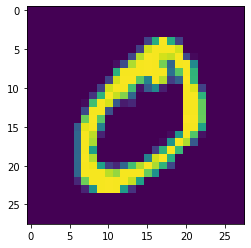

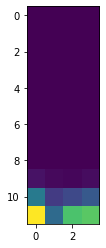

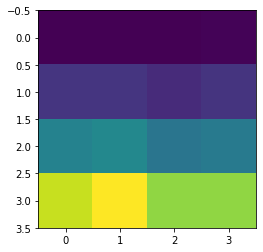

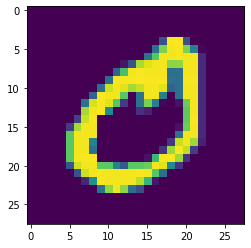

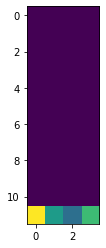

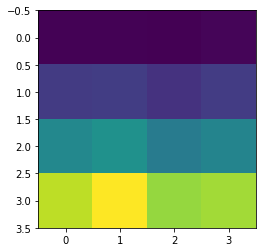

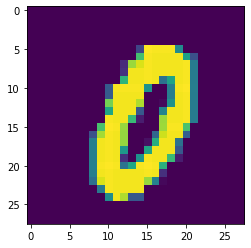

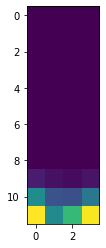

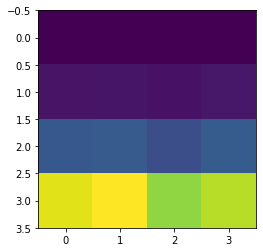

 training epoch 1


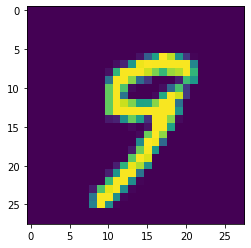

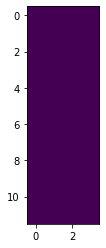

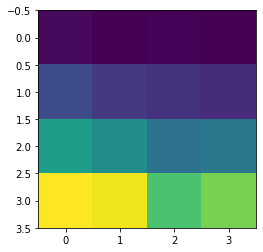

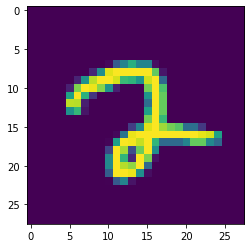

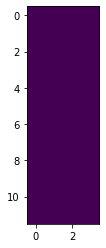

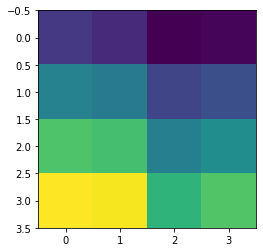

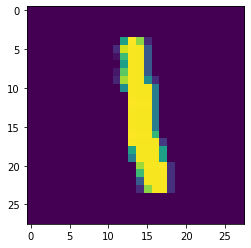

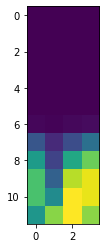

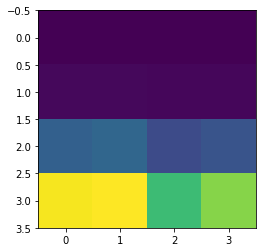

 training epoch 2


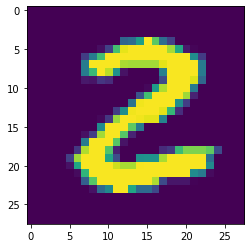

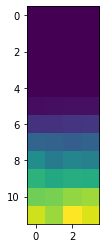

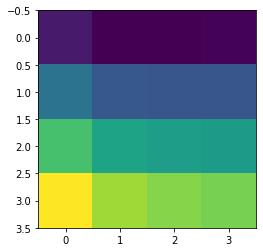

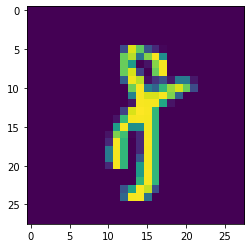

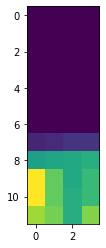

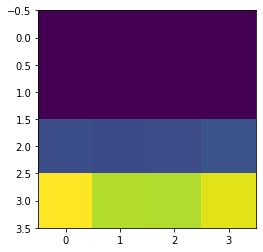

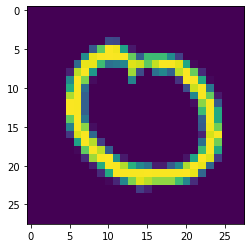

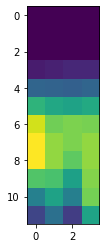

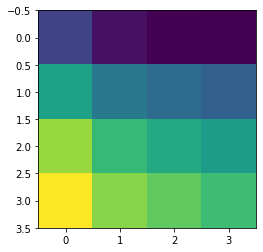

 training epoch 3


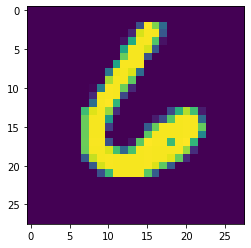

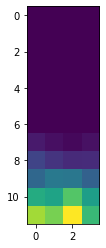

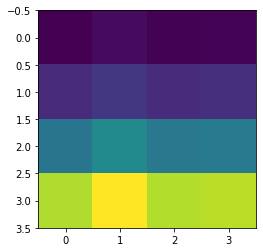

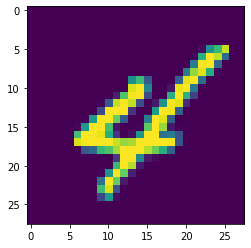

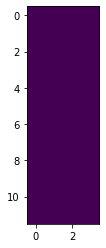

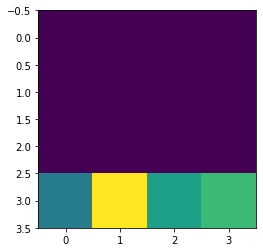

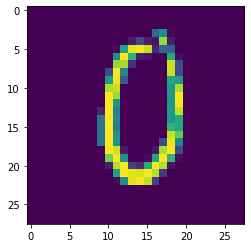

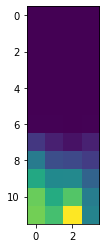

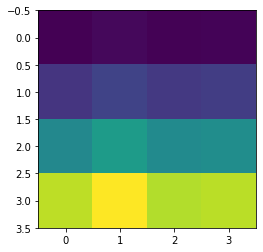

 training epoch 4


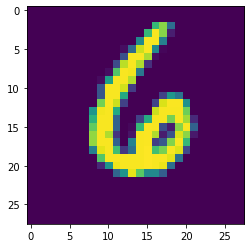

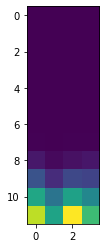

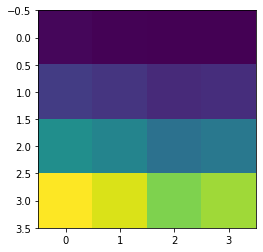

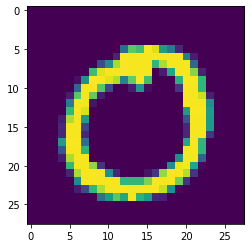

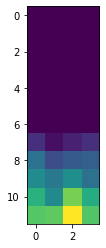

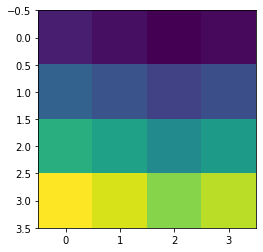

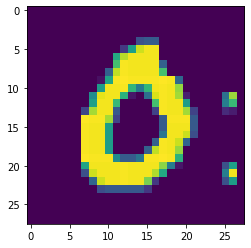

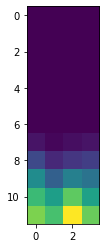

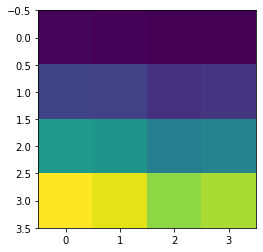

 training epoch 5


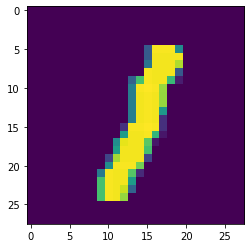

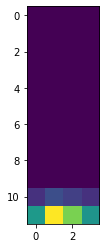

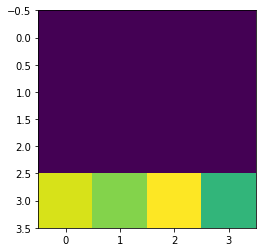

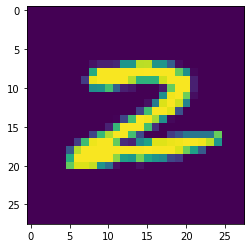

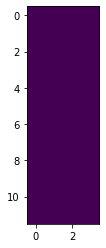

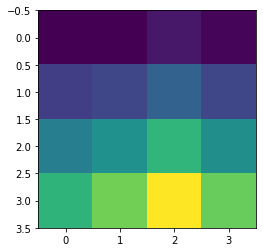

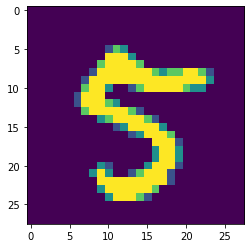

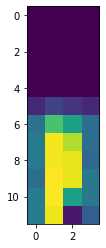

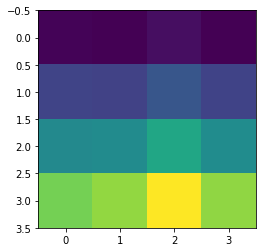

 training epoch 6


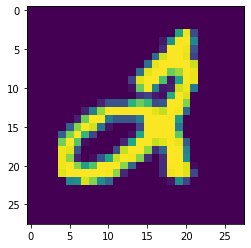

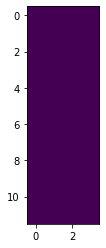

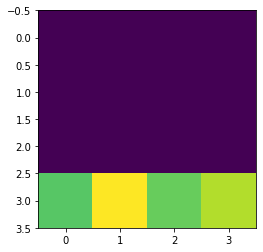

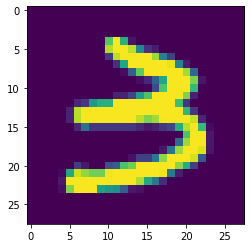

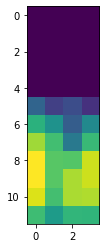

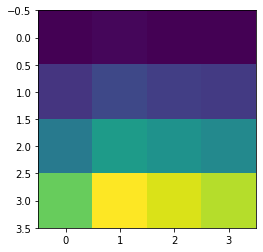

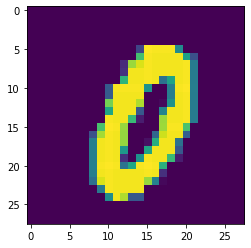

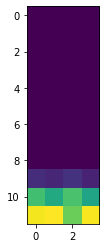

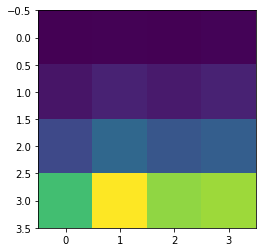

 training epoch 7


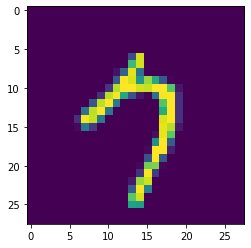

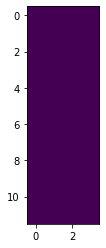

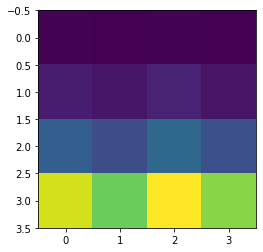

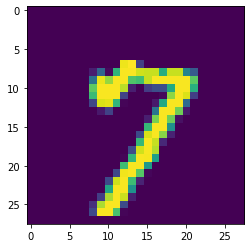

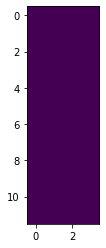

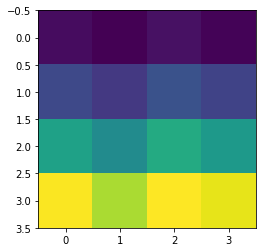

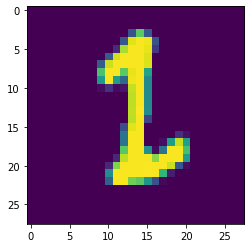

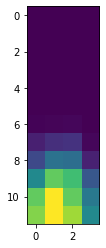

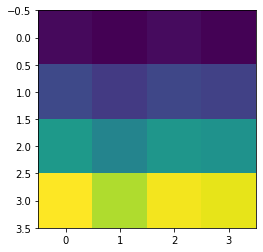

 training epoch 8


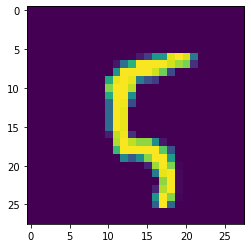

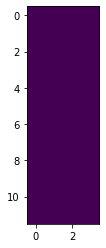

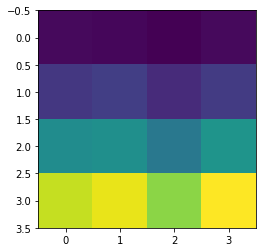

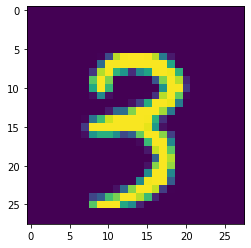

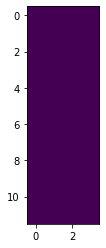

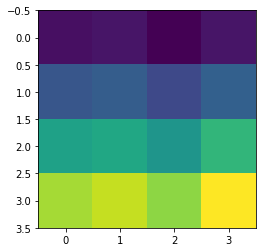

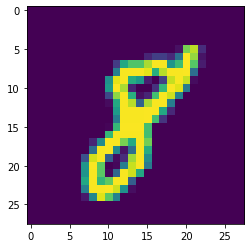

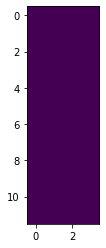

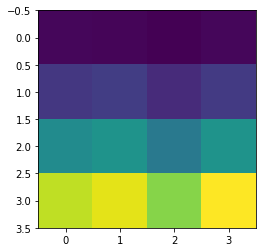

 training epoch 9


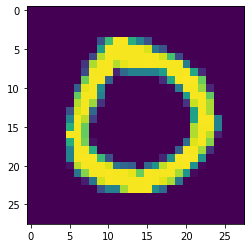

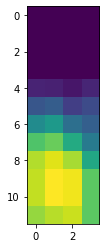

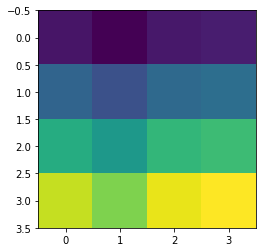

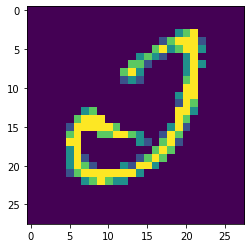

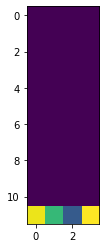

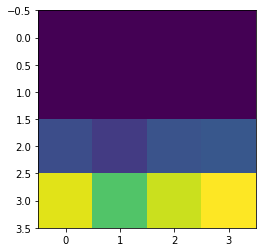

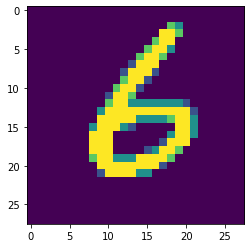

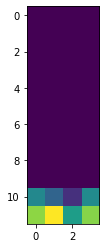

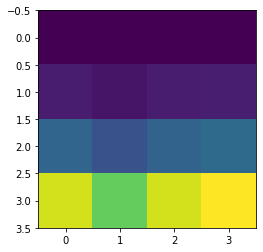

 training epoch 10


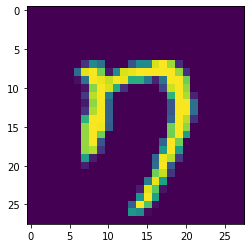

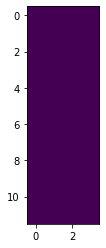

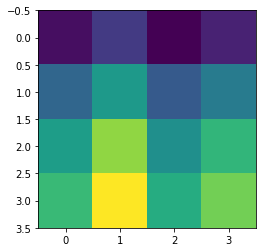

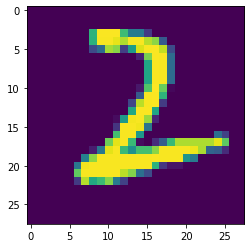

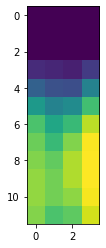

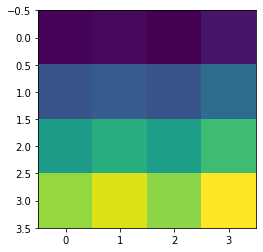

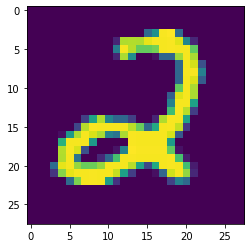

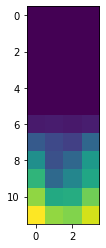

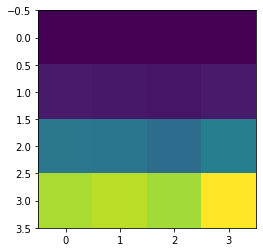

 training epoch 11


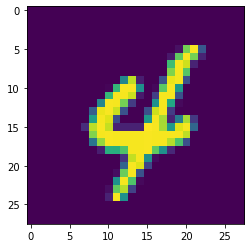

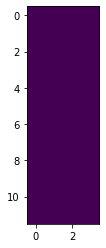

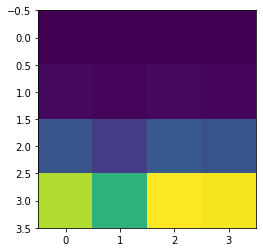

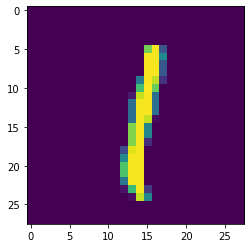

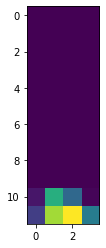

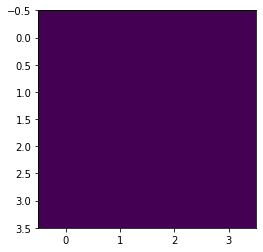

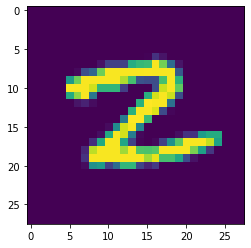

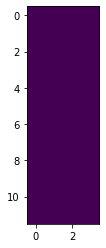

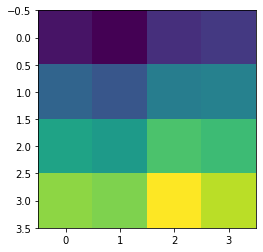

 training epoch 12


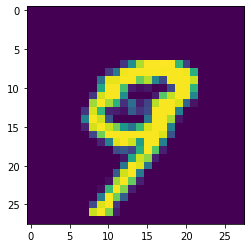

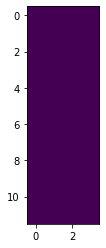

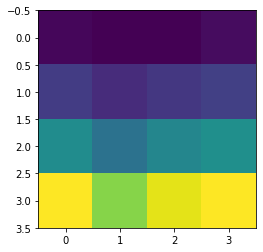

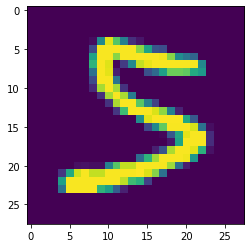

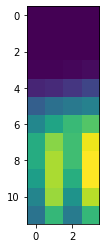

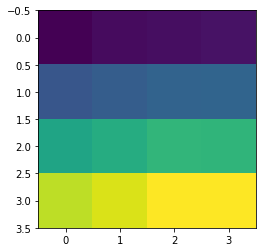

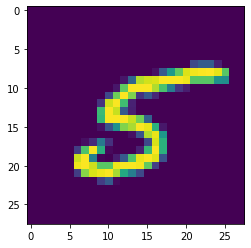

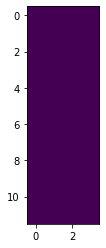

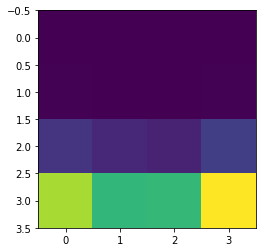

 training epoch 13


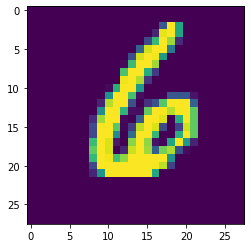

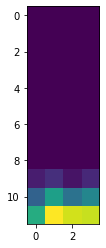

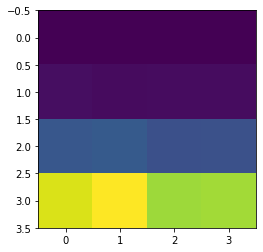

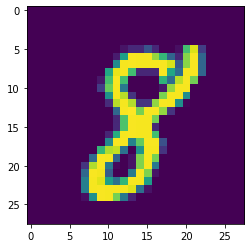

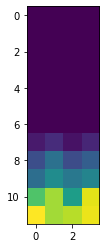

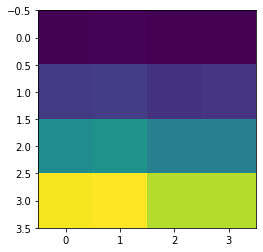

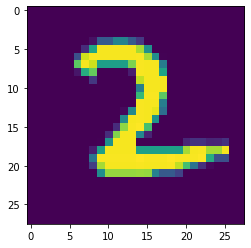

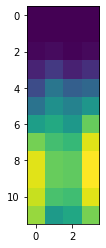

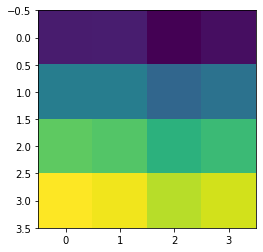

 training epoch 14


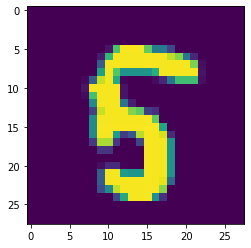

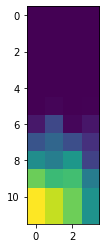

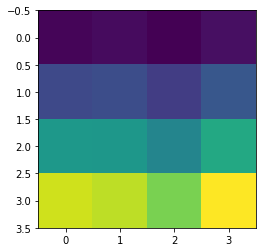

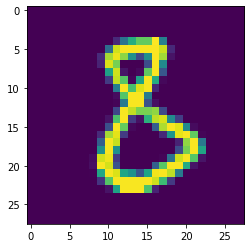

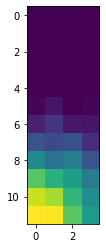

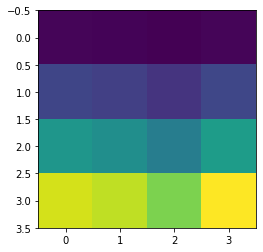

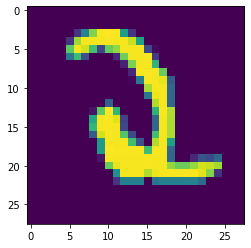

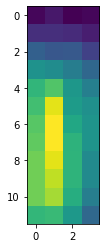

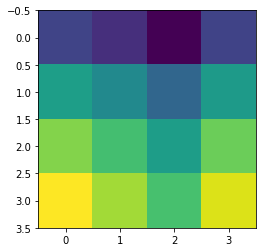

In [26]:
c=0
b=0
train_error_list=[]
test_error_list=[]

bt_layer_ep1 = []
bt_layer_ep15 = []

train_accuracy_list=[]
test_accuracy_list=[]

W1=0
W2=0
r1=0
r2=0
dvW1 = 0
dvW2 = 0


#change the variant in the train function if you want to see results for other variants 
# 1. "vanilla" for Vanilla SGD
# 2. "momentum" for Momentum SGD
# 3. "rmsprop" for RMSProp SGD 


for i in range(0,15):
    print(f" training epoch {i}")
    #last argument tells the variant that can be tested - can be run with the different variants as mentioned above
    train_err,W1,W2,r1, r2, dvW1,dvW2,actual,predicted=train(x_train,y_train,i, W1,W2,r1, r2,dvW1,dvW2,"vanilla" )
    train_error_list.append(train_err/np.shape(x_train)[0]) #train error
    train_accuracy = accuracy_metric(actual, predicted)     #train accuracy
    train_accuracy_list.append(train_accuracy)
    
    test_error, actual,predicted,bt_layer = test(x_test,y_test,W1,W2) 
    test_error_list.append(test_error/np.shape(x_test)[0])    #test error 
    test_accuracy = accuracy_metric(actual, predicted)        #test accuracy
    test_accuracy_list.append(test_accuracy)
    if(i==0):
        bt_layer_ep1 = bt_layer
    if(i==14):
        bt_layer_ep15 = bt_layer

    x_train,y_train= shuffle(x_train,y_train)              #shuffle train data after every epoch

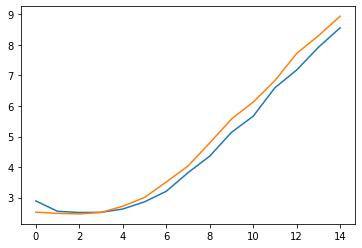

In [27]:
plt.plot(train_error_list)
plt.plot(test_error_list)

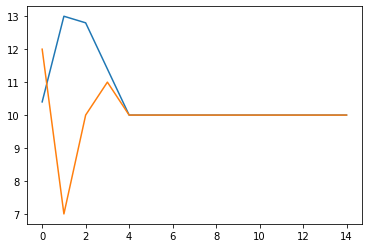

In [28]:
plt.plot(train_accuracy_list)
plt.plot(test_accuracy_list)

In [29]:
print(f"Training accuracy {max(train_accuracy_list)}")
print(f"Test accuracy {max(test_accuracy_list)}")

Training accuracy 13.0
Test accuracy 12.0


## Question 6 

In [30]:
from sklearn.manifold import TSNE
from matplotlib.colors import ListedColormap

keys = [0,1,2,3,4,5,6,7,8,9]
colour_list = ['blue', 'green', 'red', 'black', 'cyan', 'magenta', 'yellow','0.75', '#eebbbf', '#daddad', ]
def plot_tsne(bt_layer):
    tsne = TSNE(n_components=2,perplexity=5).fit_transform(bt_layer)
    tx = tsne[:, 0]
    ty = tsne[:, 1]
    
    colours= ListedColormap(colour_list)
    scatter=plt.scatter(tx,ty,marker='o',c=actual, cmap=colours)
    plt.legend(handles=scatter.legend_elements()[0], labels=keys)
    plt.show()

/home/sid/anaconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/sid/anaconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


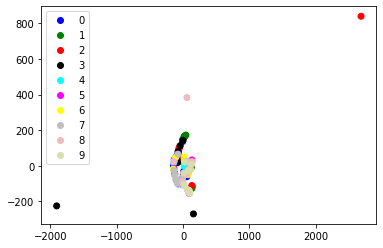

In [31]:
plot_tsne(bt_layer_ep1)

/home/sid/anaconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/sid/anaconda3/envs/pytorch/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


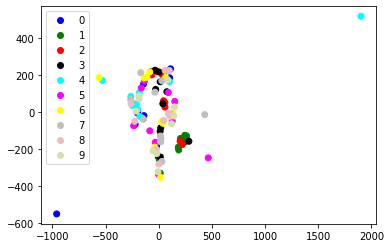

In [32]:
plot_tsne(bt_layer_ep15)